参考：https://zhuanlan.zhihu.com/p/33223782

本notebook基于tensorflow2，部分接口与版本1不一致。

 导入库包

In [1]:
import tensorflow as tf
# 为显示图片
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%pylab inline
# 为数据操作
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


一、写入tfrecord

1. 生成数据


标量
type:int64
shape: ()
样本0
1
样本1
2
样本2
3

向量
type:float32
shape: (3,)
样本0
[0.1 0.1 0.1]
样本1
[0.2 0.2 0.2]
样本2
[0.3 0.3 0.3]

矩阵
type:float32
shape: (2, 3)
样本0
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]]
样本1
[[0.2 0.2 0.2]
 [0.2 0.2 0.2]]
样本2
[[0.3 0.3 0.3]
 [0.3 0.3 0.3]]

张量
type:uint8
shape: (100, 100, 3)


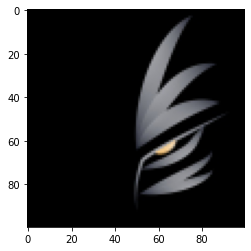

In [2]:
# 精度3位
np.set_printoptions(precision=3)
# 用于显示数据
def display(alist, show = True):
    print('type:%s\nshape: %s' %(alist[0].dtype,alist[0].shape))
    if show:
        for i in range(3):
            print('样本%s\n%s' %(i,alist[i]))

scalars = np.array([1,2,3],dtype=int64)
print('\n标量')
display(scalars)

vectors = np.array([[0.1,0.1,0.1],
                   [0.2,0.2,0.2],
                   [0.3,0.3,0.3]],dtype=float32)
print('\n向量')
display(vectors)

matrices = np.array([np.array((vectors[0],vectors[0])),
                    np.array((vectors[1],vectors[1])),
                    np.array((vectors[2],vectors[2]))],dtype=float32)
print('\n矩阵')
display(matrices)

# shape of image：(806,806,3)
img=mpimg.imread('../data/tfrecord/YJango.jpg') # 我的头像
tensors = np.array([img,img,img])
# show image
print('\n张量')
display(tensors, show = False)
plt.imshow(img)

2. 写入tfrecord file

In [7]:
tfwriter = tf.io.TFRecordWriter('../data/tfrecord/test.tfrecord')
# 这里我们将会写3个样本，每个样本里有4个feature：标量，向量，矩阵，张量
for i in range(3):
            # 创建字典
    features={}
    # 写入标量，类型Int64，由于是标量，所以"value=[scalars[i]]" 变成list
    features['scalar'] = tf.train.Feature(int64_list=tf.train.Int64List(value=[scalars[i]]))
    
    # 写入向量，类型float，本身就是list，所以"value=vectors[i]"没有中括号
    features['vector'] = tf.train.Feature(float_list = tf.train.FloatList(value=vectors[i]))
    
    # 写入矩阵，类型float，本身是矩阵，一种方法是将矩阵flatten成list
    features['matrix'] = tf.train.Feature(float_list = tf.train.FloatList(value=matrices[i].reshape(-1)))
    # 然而矩阵的形状信息(2,3)会丢失，需要存储形状信息，随后可转回原形状
    features['matrix_shape'] = tf.train.Feature(int64_list = tf.train.Int64List(value=matrices[i].shape))
    
    # 写入张量，类型float，本身是三维张量，另一种方法是转变成字符类型存储，随后再转回原类型
    features['tensor']         = tf.train.Feature(bytes_list=tf.train.BytesList(value=[tensors[i].tostring()]))
    # 存储丢失的形状信息(806,806,3)
    features['tensor_shape'] = tf.train.Feature(int64_list = tf.train.Int64List(value=tensors[i].shape))
  
    tf_features = tf.train.Features(feature=features)
    tf_example = tf.train.Example(features=tf_features)
    tf_serialized = tf_example.SerializeToString()
    tfwriter.write(tf_serialized)
    
tfwriter.close()

二、导入tfrecord


In [8]:
# 从多个tfrecord文件中导入数据到Dataset类 （这里用两个一样）
filenames = ["../data/tfrecord/test.tfrecord", "../data/tfrecord/test.tfrecord"]
dataset = tf.data.TFRecordDataset(filenames)

由于从tfrecord文件中导入的样本是刚才写入的tf_serialized序列化样本，所以我们需要对每一个样本进行解析。这里就用dataset.map(parse_function)来对dataset里的每个样本进行相同的解析操作。

1. 创建解析函数parse_function

In [16]:
# 占位
def parse_function(example_proto):
    pass

Step1: 样本解析字典
该字典存放着所有feature的解析方式，key为feature名，value为feature的解析方式。

解析方式有两种：

**定长特征解析：**

tf.io.FixedLenFeature(shape, dtype, default_value)

shape：可当reshape来用，如vector的shape从(3,)改动成了(1,3)。

注：如果写入的feature使用了.tostring() 其shape就是()

dtype：必须是tf.float32， tf.int64， tf.string中的一种。

default_value：feature值缺失时所指定的值。


**不定长特征解析：**

tf.io.VarLenFeature(dtype)

注：可以不明确指定shape，但得到的tensor是SparseTensor。

In [11]:
parse_dict={# 这里没用default_value，随后的都是None
            'scalar': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None), 
             
            # vector的shape刻意从原本的(3,)指定成(1,3)
            'vector': tf.io.FixedLenFeature(shape=(1,3), dtype=tf.float32), 
                
            # 使用 VarLenFeature来解析
            'matrix': tf.io.VarLenFeature(dtype=dtype('float32')), 
            'matrix_shape': tf.io.FixedLenFeature(shape=(2,), dtype=tf.int64), 
            
            # tensor在写入时 使用了toString()，shape是()
            # 但这里的type不是tensor的原type，而是字符化后所用的tf.string，随后再回转成原tf.uint8类型
            'tensor': tf.io.FixedLenFeature(shape=(), dtype=tf.string), 
            'tensor_shape': tf.io.FixedLenFeature(shape=(3,), dtype=tf.int64)}

Step2:解析样本

In [14]:
# 把序列化样本和解析字典送入函数里得到解析的样本
#parsed_example = tf.io.parse_single_example(example_proto, parse_dict)

NameError: name 'example_proto' is not defined

Step 3. 转变特征

得到的parsed_example也是一个字典，其中每个key是对应feature的名字，value是相应的feature解析值。如果使用了下面两种情况，则还需要对这些值进行转变。其他情况则不用。

string类型：tf.decode_raw(parsed_feature, type) 来解码

注：这里type必须要和当初.tostring()化前的一致。如tensor转变前是tf.uint8，这里就需是tf.uint8；转变前是tf.float32，则tf.float32

VarLen解析：由于得到的是SparseTensor，所以视情况需要用tf.sparse_tensor_to_dense(SparseTensor)来转变成DenseTensor

Step 4. 改变形状

到此为止得到的特征都是向量，需要根据之前存储的shape信息对每个feature进行reshape。

In [23]:
#  解析函数汇总
def parse_function(example_proto):
    #step1
    parse_dict={# 这里没用default_value，随后的都是None
            'scalar': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None), 
             
            # vector的shape刻意从原本的(3,)指定成(1,3)
            'vector': tf.io.FixedLenFeature(shape=(1,3), dtype=tf.float32), 
                
            # 使用 VarLenFeature来解析
            'matrix': tf.io.VarLenFeature(dtype=dtype('float32')), 
            'matrix_shape': tf.io.FixedLenFeature(shape=(2,), dtype=tf.int64), 
            
            # tensor在写入时 使用了toString()，shape是()
            # 但这里的type不是tensor的原type，而是字符化后所用的tf.string，随后再回转成原tf.uint8类型
            'tensor': tf.io.FixedLenFeature(shape=(), dtype=tf.string), 
            'tensor_shape': tf.io.FixedLenFeature(shape=(3,), dtype=tf.int64)}
    #step2
    parsed_example = tf.io.parse_single_example(example_proto, parse_dict)
    #step3
    # 解码字符
    parsed_example['tensor'] = tf.io.decode_raw(parsed_example['tensor'], tf.uint8)
    # 稀疏表示 转为 密集表示
    parsed_example['matrix'] = tf.compat.v1.sparse_tensor_to_dense(parsed_example['matrix'])
    #step4
    # 转变matrix形状
    parsed_example['matrix'] = tf.reshape(parsed_example['matrix'], parsed_example['matrix_shape'])
    # 转变tensor形状
    parsed_example['tensor'] = tf.reshape(parsed_example['tensor'], parsed_example['tensor_shape'])
    # return 
    return parsed_example

In [26]:
parsed_dataset = dataset.map(parse_function)

In [28]:
print(parsed_dataset)

<MapDataset shapes: {matrix: (None, None), matrix_shape: (2,), scalar: (), tensor: (None, None, None), tensor_shape: (3,), vector: (1, 3)}, types: {matrix: tf.float32, matrix_shape: tf.int64, scalar: tf.int64, tensor: tf.uint8, tensor_shape: tf.int64, vector: tf.float32}>


2. 创建迭代器

In [33]:
# 创建获取数据集中样本的迭代器
iterator = tf.compat.v1.data.make_one_shot_iterator(parsed_dataset)

3. 获取样本

==============example 1 ==============
scalar: value: tf.Tensor(1, shape=(), dtype=int64) | shape: () | type: <dtype: 'int64'>
vector shape: (1, 3) | type: <dtype: 'float32'>
matrix shape: (2, 3) | type: <dtype: 'float32'>
tensor shape: (100, 100, 3) | type: <dtype: 'uint8'>
==============example 2 ==============
scalar: value: tf.Tensor(2, shape=(), dtype=int64) | shape: () | type: <dtype: 'int64'>
vector shape: (1, 3) | type: <dtype: 'float32'>
matrix shape: (2, 3) | type: <dtype: 'float32'>
tensor shape: (100, 100, 3) | type: <dtype: 'uint8'>
==============example 3 ==============
scalar: value: tf.Tensor(3, shape=(), dtype=int64) | shape: () | type: <dtype: 'int64'>
vector shape: (1, 3) | type: <dtype: 'float32'>
matrix shape: (2, 3) | type: <dtype: 'float32'>
tensor shape: (100, 100, 3) | type: <dtype: 'uint8'>
==============example 4 ==============
scalar: value: tf.Tensor(1, shape=(), dtype=int64) | shape: () | type: <dtype: 'int64'>
vector shape: (1, 3) | type: <dtype: 'float32

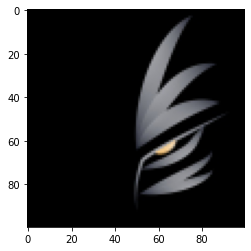

In [34]:
i=1
while True:
    # 不断的获得下一个样本
    try:
        # 获得的值直接属于graph的一部分，所以不再需要用feed_dict来喂
        next_element = iterator.get_next()
        scalar,vector,matrix,tensor = (next_element['scalar'],
                                                next_element['vector'],
                                                next_element['matrix'],
                                                next_element['tensor'])
    # 如果遍历完了数据集，则返回错误
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        # 显示每个样本中的所有feature的信息，只显示scalar的值
        print('==============example %s ==============' %i)
        print('scalar: value: %s | shape: %s | type: %s' %(scalar, scalar.shape, scalar.dtype))
        print('vector shape: %s | type: %s' %(vector.shape, vector.dtype))
        print('matrix shape: %s | type: %s' %(matrix.shape, matrix.dtype))
        print('tensor shape: %s | type: %s' %(tensor.shape, tensor.dtype))
    i+=1
plt.imshow(tensor)

4.shuffle

In [38]:
shuffle_dataset = parsed_dataset.shuffle(buffer_size=10000)
iterator = tf.compat.v1.data.make_one_shot_iterator(shuffle_dataset)
i=1
while True:
    try:
        next_element=iterator.get_next()
        scalar=next_element['scalar']
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('example %s | scalar: value: %s' %(i,scalar))
    i+=1

example 1 | scalar: value: tf.Tensor(1, shape=(), dtype=int64)
example 2 | scalar: value: tf.Tensor(3, shape=(), dtype=int64)
example 3 | scalar: value: tf.Tensor(2, shape=(), dtype=int64)
example 4 | scalar: value: tf.Tensor(1, shape=(), dtype=int64)
example 5 | scalar: value: tf.Tensor(2, shape=(), dtype=int64)
example 6 | scalar: value: tf.Tensor(3, shape=(), dtype=int64)
End of dataset


5. batch

In [43]:
batch_dataset = shuffle_dataset.batch(3)
iterator = tf.compat.v1.data.make_one_shot_iterator(batch_dataset)

i = 1
while True:
    # 不断的获得下一个样本
    try:
        next_element = iterator.get_next()
        scalar = next_element['scalar']
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('example %s | scalar: value: %s' %(i,scalar))
    i+=1

example 1 | scalar: value: tf.Tensor([1 2 2], shape=(3,), dtype=int64)
example 2 | scalar: value: tf.Tensor([3 1 3], shape=(3,), dtype=int64)
End of dataset


6. batch_padding  

也可以在每个batch内进行padding,对单个样本进行padding

padded_shapes指定了内部数据是如何pad的。

- rank数要与元数据对应

- rank中的任何一维被设定成None或-1时都表示将pad到该batch下的最大长度


In [46]:
batch_padding_dataset = parsed_dataset.padded_batch(4, 
                        padded_shapes={'scalar': [],
                                       'vector': [-1,5],
                                       'matrix': [None,None],
                                       'matrix_shape': [None],
                                       'tensor': [None,None,None],
                                       'tensor_shape': [None]})
iterator = tf.compat.v1.data.make_one_shot_iterator(batch_padding_dataset)

i = 1
while True:
    try:
        next_element = iterator.get_next()
        scalar,vector,matrix,tensor = (next_element['scalar'],
                                                next_element['vector'],
                                                next_element['matrix'],
                                                next_element['tensor'])
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('==============example %s ==============' %i)
        print('scalar: value: %s | shape: %s | type: %s' %(scalar, scalar.shape, scalar.dtype))
        print('padded vector value\n%s:\nvector shape: %s | type: %s' %(vector, vector.shape, vector.dtype))
        print('matrix shape: %s | type: %s' %(matrix.shape, matrix.dtype))
        print('tensor shape: %s | type: %s' %(tensor.shape, tensor.dtype))
    i+=1

==============example 1 ==============
scalar: value: tf.Tensor([1 2 3 1], shape=(4,), dtype=int64) | shape: (4,) | type: <dtype: 'int64'>
padded vector value
tf.Tensor(
[[[0.1 0.1 0.1 0.  0. ]]

 [[0.2 0.2 0.2 0.  0. ]]

 [[0.3 0.3 0.3 0.  0. ]]

 [[0.1 0.1 0.1 0.  0. ]]], shape=(4, 1, 5), dtype=float32):
vector shape: (4, 1, 5) | type: <dtype: 'float32'>
matrix shape: (4, 2, 3) | type: <dtype: 'float32'>
tensor shape: (4, 100, 100, 3) | type: <dtype: 'uint8'>
==============example 2 ==============
scalar: value: tf.Tensor([2 3], shape=(2,), dtype=int64) | shape: (2,) | type: <dtype: 'int64'>
padded vector value
tf.Tensor(
[[[0.2 0.2 0.2 0.  0. ]]

 [[0.3 0.3 0.3 0.  0. ]]], shape=(2, 1, 5), dtype=float32):
vector shape: (2, 1, 5) | type: <dtype: 'float32'>
matrix shape: (2, 2, 3) | type: <dtype: 'float32'>
tensor shape: (2, 100, 100, 3) | type: <dtype: 'uint8'>
End of dataset


7. epoch

使用.repeat(num_epochs) 来指定要遍历几遍整个数据集

In [47]:
# num
num_epochs = 2
epoch_dataset = parsed_dataset.repeat(num_epochs)
iterator = tf.compat.v1.data.make_one_shot_iterator(epoch_dataset)

i = 1
while True:
    try:
        next_element = iterator.get_next()
        scalar = next_element['scalar']
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('example %s | scalar: value: %s' %(i,scalar))
    i+=1

example 1 | scalar: value: tf.Tensor(1, shape=(), dtype=int64)
example 2 | scalar: value: tf.Tensor(2, shape=(), dtype=int64)
example 3 | scalar: value: tf.Tensor(3, shape=(), dtype=int64)
example 4 | scalar: value: tf.Tensor(1, shape=(), dtype=int64)
example 5 | scalar: value: tf.Tensor(2, shape=(), dtype=int64)
example 6 | scalar: value: tf.Tensor(3, shape=(), dtype=int64)
example 7 | scalar: value: tf.Tensor(1, shape=(), dtype=int64)
example 8 | scalar: value: tf.Tensor(2, shape=(), dtype=int64)
example 9 | scalar: value: tf.Tensor(3, shape=(), dtype=int64)
example 10 | scalar: value: tf.Tensor(1, shape=(), dtype=int64)
example 11 | scalar: value: tf.Tensor(2, shape=(), dtype=int64)
example 12 | scalar: value: tf.Tensor(3, shape=(), dtype=int64)
End of dataset
